# Chinese Carplate Character Recognition

The dataset of characters are cropped from carplate and augmented using roboflow, it represents 100 training images and 20 test images. These are Chinese provincial characters, and are coded in the `.yaml` files with the following convention:
    
    code ==> Character (Pinyin) in image
    1. 0 ==> gan
    2. 1 ==> gui
    3. 2 ==> jing
    4. 3 ==> liao
    5. 4 ==> lu
    6. 5 ==> wan
    7. 6 ==> xiang
    8. 7 ==> yu
    9. 8 ==> yun
    10. 9 ==> zhe
    
The implementation in this notebook has been done in `PyTorch`, and uses a modified version of the `LeNet-5` CNN architecture (<a href = "http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf" target = "_blank">original paper from 1998</a>).

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/ML"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['dataset',
 'roboflow & yolov5',
 'License Plate Recognition using Tesseract',
 'custom.weights',
 'best.pt',
 'Car Plate Clear.v2i.yolov5pytorch',
 'yoloTrain.ipynb',
 'runs',
 'CP super resolution.ipynb',
 'province.v2i.yolov5pytorch',
 'lenet_test.ipynb',
 'submission.csv',
 'Project Presentation',
 'exp1.csv',
 'exp2.csv',
 'exp4.csv',
 'exp5.csv',
 'exp3.csv',
 'Project Report.gdoc',
 'modified-lenet-5-chinese.ipynb']

Some of the libraries I know that I'll be using right off the bat. A few might not even be required, but I'll keep them in the cell, because that gives an insight into my thought-process while making the model. Considering it'll increase the time taken to run the cell, not a very ideal thing to do - but few things in this world are.

In [ ]:
# ! pip3 install torch torchvision

In [ ]:
# ! pip3 install numpy
# ! pip3 install pandas
# ! pip3 install matplotlib
# ! pip3 install sklearn

In [ ]:
import torch
import torchvision
import cv2
import imutils
from PIL import Image
import torch.nn
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split as tts

Confirming if the GPU is available for training:

In [ ]:
torch.cuda.is_available()

True

Excellent :)))))

# Visualisation

The following cell plots a set of five random samples from the `/province.v2i.yolov5pytorch/train/images/` folder. This'll help identify basic truths about the image data that I'll be dealing with.

JPEG
(64, 64)


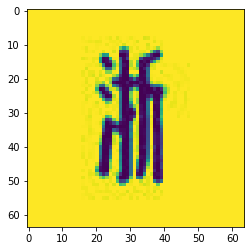

255 ,  0


In [ ]:
%matplotlib inline

image = Image.open('./province.v2i.yolov5pytorch/train/Lenet_Training_set_4/train_original_zhe1.jpg_ffec9225-7302-4a9a-b4bf-ca7a304d3fe3.jpg')
print(image.format)
arr = np.array(image)
print(arr.shape)
plt.imshow(arr)
plt.show()
print(arr.max(), ', ', 0)

This clearly shows that:
1. the image is `500x500` (from `print(arr.shape)`)
2. grayscale (from the fact that there's only one channel - nevermind what you see. `pyplot.plot` colormaps aren't the most reliable)
3. is a `JPEG` (self-evident from the o/p. Less evident from the beautiful `JPEG` artifacts, but evident nonetheless)

From the max pixel value, it is fairly certain the range of intensities will be `0-255`.

# Importing image labels & raw data

`train.csv` and `test.csv` contain 2 columns: `id` - which gives the name of the image in the `Training_Data` folder, and `code` - which contains the true encodings of the character in the image (as written in the introduction).

In [ ]:
train = pd.read_csv('./province.v2i.yolov5pytorch/train/train_4.csv')
val = pd.read_csv('./province.v2i.yolov5pytorch/train/train_3.csv')
# val = pd.read_csv('./province.v2i.yolov5pytorch/test/test.csv')

Performing necessary preprocessing on raw image data:

1. **putting it into a `NumPy` array**: to ease mathematical operations
2. **scaling**: brings the pixel values from `[0, 255]` to `[0, 1]`
3. **Mean-normalisation**: brings the pixel values from `[0, 1]` to `[-1, 1]`

In [ ]:
X_train = []
X_val = []

for i in train.id:
  img = cv2.imread('./province.v2i.yolov5pytorch/train/Lenet_Training_set_4/' + str(i)+'.jpg' ,cv2.IMREAD_GRAYSCALE)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # img = cv2.cvtColor(img,dst,CV_BGR2GRAY)
  img_n = np.asarray(img)
  img_n = img_n/255
  img_n = (img_n - 0.5)/0.5
  X_train.append(img_n)   
for j in val.id:
  # if i in (train.id):
  #   print("True!!!!!")
  # print(j)
  # img = Image.open('./province.v2i.yolov5pytorch/test/images/' + str(j) + '.jpg')
  img = Image.open('./province.v2i.yolov5pytorch/train/Lenet_Training_set_3/' + str(j)+'.jpg')
  img_n = np.asarray(img)
  img_n = img_n/255
  img_n = (img_n - 0.5)/0.5
  # X_train.append(img_n)
  X_val.append(img_n)


# print(type(y_train))
# y_train = train.code.append(val.code)

y_train = train.code
y_val = val.code

In [ ]:
# X_train = []
# X_val = []

# for i in train.id:
#   img = Image.open('./province.v2i.yolov5pytorch/train/Lenet_Training_set_3/' + str(i)+'.jpg')
#   img_n = np.asarray(img)
#   img_n = img_n/255
#   img_n = (img_n - 0.5)/0.5
#   X_train.append(img_n)   
# for j in val.id:
#   # if i in (train.id):
#   #   print("True!!!!!")
#   # print(j)
#   img = Image.open('./province.v2i.yolov5pytorch/test/images/' + str(j) + '.jpg')
#   # img = Image.open('./province.v2i.yolov5pytorch/train/Lenet_Training_set_3/' + str(j)+'.jpg')
#   img_n = np.asarray(img)
#   img_n = img_n/255
#   img_n = (img_n - 0.5)/0.5
#   X_val.append(img_n)
#   # X_val.append(img_n)


# # print(type(y_train))
# # y_train = train.code.append(val.code)



`mean` and `std_dev` were taken as `0.5` and `0.5` - since the pixel values were scaled from `[0, 255]` to `[0, 1]`. I could go on and use the actual mean and standard deviation of the dataset, but this seems to work fine. I might try using that in the future and check what effect it has on the accuracy and loss landscape.

In [ ]:
X_train = np.array(X_train)
X_train = X_train.astype(np.float32)

y_train = np.array(y_train)
y_train = y_train.astype(np.float32)

X_val = np.array(X_val)
X_val = X_val.astype(np.float32)

y_val = np.array(y_val)
y_val = y_val.astype(np.float32)

print('Train set dims = ', (X_train.shape))
print(y_train.shape)

Train set dims =  (10000, 64, 64)
(10000,)


In [ ]:
train_data = X_train
val_data = X_val
train_label = y_train
val_label = y_val

In [ ]:
# from sklearn.model_selection import train_test_split


# train_data, val_data, train_label, val_label = train_test_split(X_train, y_train, test_size=1 / 4, random_state=0)

In [ ]:
print(X_train.shape)
print(train_data.shape)

(10000, 64, 64)
(10000, 64, 64)


These shapes confirm that the array is 64x64 in shape, with the 

1.   List item
2.   List item

training set having 108 samples.

Now for a final look at the `X_train` array, to verify whether I've loaded the images correctly:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0f3e0d6690>,
 <matplotlib.image.AxesImage at 0x7f0f3e05bb50>)

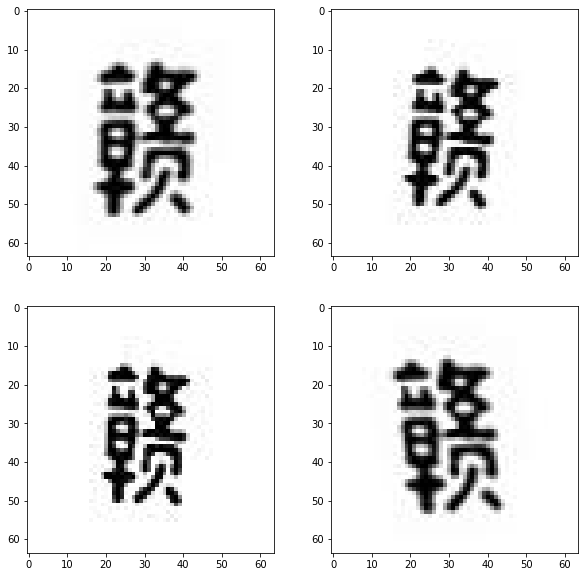

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1), plt.imshow(X_train[random.randint(0, 107)], cmap='gray')
plt.subplot(2, 2, 2), plt.imshow(X_train[random.randint(0, 107)], cmap='gray')
plt.subplot(2, 2, 3), plt.imshow(X_train[random.randint(0, 107)], cmap='gray')
plt.subplot(2, 2, 4), plt.imshow(X_train[random.randint(0, 107)], cmap='gray')

In [ ]:
from torch import nn
from torch import optim
import torch

# Implementing a (very) modified `LeNet-5` architecture

1. `3x3` conv, stride = `1` (`6` filters)
2. `3x3` conv, stride = `1` (`6` filters)
3. Max pooling, f = `2`, s = `2`
4. `3x3` conv, stride = `1` (`16` filters)
5. Max pooling, f = `2`, s = `2`
6. FCL (`500` units)
7. FCL (`90` units)
8. Output layer (`15` units) 

# Differences from the original `LeNet-5` paper:

**1.** instead of average pooling, **max pooling** is used

**2.** instead of `sigmoid` and `tanh` non-linearities, **`ReLU`** is used

**3.** The number of units in each FCL is decided as per the 64x64 **size of the image data**, and also on the **nature of the characters used** in the Chinese language. The following were the justifications made in the original paper:


   * The original `LeNet-5` paper specified that the first "full-connected layer" with `120` units <u>was in fact a convolution layer</u>, but since the kernel size matched the input size for that layer, it <u>functioned as a full-connected layer</u>. Here, **I explicitly state it as a FCL**, and <u>made it to have 500 units to capture **the finer details of Chinese writing**</u>.
   * The choice of `84` units for the next FCL was based on the fact that <u>this model could be used to identify characters from a `7x12` bitmap</u> - not necessarily numerals but also "stylised characters", as they were called in the original paper.
 
**4.** the kernel (filter) size is now `3x3` - since Chinese is a language with fine and distinct strokes, <u>which might be blurred and thus, hidden if I use a larger kernel</u>.

**5.** the first `5x5` convolution is replaced by 2 consecutive `3x3` convolutions, to:

  * <u>increase non-linearities</u> in the network, since there is an extra layer now. This helps to make the model a tiny bit more robust.
  
  * decrease number of trainable parameters, which <u>reduces overfitting</u> in the model and <u>increases computational efficiency</u>.

In [ ]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(

            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.01),   
            nn.MaxPool2d(kernel_size=2, stride=2),
      
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2) 
      )

        self.FCL = nn.Sequential(
            nn.Linear(3136, 500),
            nn.LeakyReLU(0.01),
            nn.Linear(500, 90),
            nn.LeakyReLU(0.01),
            nn.Linear(90, 10)
      )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.FCL(x)
        return x

# Choice of optimiser and loss function

The ***optimiser*** used is `optim.Adam`, with a learning-rate of `0.0005`, which is one of the better choices as per <a href = "https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2" target="_blank">this Medium article</a>. The Adam optimiser is generally deemed to converge faster than stochastic gradient descent, which is a major point in its favour.

The ***loss function*** used is `nn.CrossEntropyLoss` since this is a multi-class classification problem. Since it inherently includes a `softmax` operation, I didn't include a separate `softmax` layer in my network architecture earlier. It'll be included later on while making the predictions, along with `np.argmax`.

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCL): Sequential(
    (0): Linear(in_features=3136, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=500, out_features=90, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=90, out_features=10, bias=True)
  )
)


Now to finally train the model on the entire training set:

In [ ]:
# X_train.shape: (108, 500, 500)
train_data = train_data.reshape(train_data.shape[0], 1, 64, 64)
train_data  = torch.from_numpy(train_data)
train_label = train_label.astype(int)
train_label = torch.from_numpy(train_label)

print(train_label)

val_data = val_data.reshape(val_data.shape[0], 1, 64, 64)
val_data  = torch.from_numpy(val_data)
val_label = val_label.astype(int)
val_label = torch.from_numpy(val_label)

print(val_label)

tensor([0, 0, 0,  ..., 9, 9, 9])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       

# Training the model, setting no. of epochs

### *NOTE: the following cell WILL take a lot of time to execute, if you're using a CPU.*

*You may skip it if you wish, or use a GPU to speed up the training. I achieved an accuracy of about `93.5%` on <a href="https://www.kaggle.com/c/mnist-but-chinese/leaderboard" target="_blank">the competition leaderboard</a> at around `16-17` epochs, so you may stop there, or push forward to see the effect of a longer training duration on the model's generalisability.*

This cell will show the `CrossEntropy` losses after every epoch (i.e. a full pass of the entire training set of 10,000 samples) It can be modified suitably to show changes in loss when the model is in-between epochs, though this will necessitate changes to the plotting function too.

In [ ]:
# from sklearn.metrics import accuracy_score

In [ ]:
val_ground_truth = val_label.numpy()
train_ground_truth = train_label.numpy()

In [ ]:
def test(X_test, ground_truth):
  test_preds = model(X_test.cuda())
  p = F.softmax(test_preds).data
  p = p.cpu()
  code = []

  for i in range(len(p)):
      cache = np.argmax(p[i])
      code.append(cache.item())
  count = 0
  for i in range(len(code)):
    if ground_truth[i] == code[i]:
      #print(ground_truth[i],code[i])
      count += 1
  
  return(count/len(code))

In [ ]:
from torch.nn import functional as F
losses = []
val_losses = []
runs = []

for epoch in range(200):
  running_loss = 0
  # val_loss = 0
  for i in range(len(train_data)):
    if torch.cuda.is_available():
        train_data[i] = train_data[i].cuda()
        train_label[i] = train_label[i].cuda()

    optimizer.zero_grad()
    train_data[i] = train_data[i].unsqueeze_(0)
    train_label[i] = train_label[i].unsqueeze_(0)
    output = model(train_data[i][None, ...].cuda()) 
    loss = criterion(output, train_label[[i]].long().cuda())     
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if (i % len(train_data)) == (len(train_data) - 1):
      val_accuracy = test(val_data,val_ground_truth)
      train_accuracy = test(train_data, train_ground_truth)
      # for j in range(len(val_data)):
        # if torch.cuda.is_available():
        #   val_data[j] = val_data[j].cuda()
        #   val_label[j] = val_label[j].cuda()
        # val_data[j] = val_data[j].unsqueeze_(0)
        # val_label[j] = val_label[j].unsqueeze_(0)

        # val_output = model(val_data[j][None, ...].cuda())
        # loss_2 = criterion(val_output, val_label[[j]].long().cuda())
        # val_loss += loss_2.item()
           #'[%d, %5d] train loss: %.7f' val loss: %.7f%
      print(epoch + 1, i + 1, train_accuracy, val_accuracy)
      losses.append(train_accuracy)
      val_losses.append(val_accuracy)
      runs.append(epoch)
      running_loss = 0.0
      # val_loss = 0.0


    
  # if losses[epoch] > losses[epoch - 1]:
  #     print("Loss value increased at epoch ", epoch + 1, 
  #           "! The least value of loss so far is ", losses[epoch - 1], " and current value is ", losses[epoch])
  #     break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


1 10000 0.0977 0.1
2 10000 0.0977 0.1
3 10000 0.0977 0.1
4 10000 0.1003 0.1
5 10000 0.1998 0.19583333333333333
6 10000 0.1836 0.14166666666666666
7 10000 0.0977 0.10833333333333334
8 10000 0.4126 0.28541666666666665
9 10000 0.3791 0.19166666666666668
10 10000 0.6267 0.20833333333333334
11 10000 0.7288 0.32708333333333334
12 10000 0.9879 0.35
13 10000 0.9001 0.3333333333333333
14 10000 0.9976 0.3875
15 10000 0.9997 0.39166666666666666
16 10000 1.0 0.40208333333333335
17 10000 1.0 0.40208333333333335
18 10000 1.0 0.40625
19 10000 0.9457 0.30625
20 10000 0.9997 0.48333333333333334
21 10000 1.0 0.40625
22 10000 1.0 0.40625
23 10000 1.0 0.40625
24 10000 1.0 0.40625
25 10000 1.0 0.41041666666666665
26 10000 1.0 0.4125
27 10000 1.0 0.4125
28 10000 1.0 0.4125
29 10000 1.0 0.41458333333333336
30 10000 1.0 0.41458333333333336
31 10000 1.0 0.41458333333333336
32 10000 1.0 0.4166666666666667
33 10000 1.0 0.4166666666666667
34 10000 1.0 0.4166666666666667
35 10000 1.0 0.4166666666666667
36 10000 1.

KeyboardInterrupt: ignored

In [ ]:
# losses = []
# runs = []

# for epoch in range(len(train_data)):
#   running_loss = 0
#   for i in range(len(train_data)):
#     if torch.cuda.is_available():
#         train_data[i] = train_data[i].cuda()
#         train_label[i] = train_label[i].cuda()

#     optimizer.zero_grad()
#     train_data[i] = train_data[i].unsqueeze_(0)
#     train_label[i] = train_label[i].unsqueeze_(0)
#     output = model(train_data[i][None, ...].cuda()) 
#     loss = criterion(output, train_label[[i]].long().cuda())     
#     loss.backward()
#     optimizer.step()
#     running_loss += loss.item()
#     if (i % len(train_data)) == (len(train_data) - 1):
#       print('[%d, %5d] loss: %.7f' %
#             (epoch + 1, i + 1, running_loss / len(train_data)))
#       losses.append(running_loss/len(train_data))
#       runs.append(epoch)
#       running_loss = 0.0
  
#   if losses[epoch] > losses[epoch - 1]:
#       print("Loss value increased at epoch ", epoch + 1, 
#             "! The least value of loss so far is ", losses[epoch - 1], " and current value is ", losses[epoch])
#       break

# Plotting the changes in loss over the epochs

Execute the following to plot the graph of loss against number of epochs - this depends on whichever point you chose to stop the execution of the previous cell. The model may be in-between epochs with its training, but it'll show the loss up until the last complete epoch only.

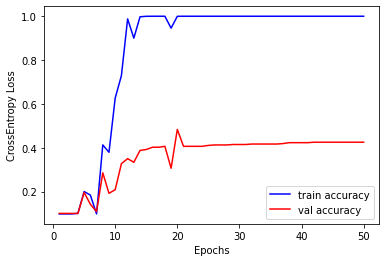

In [ ]:
import copy

runs_mod = copy.deepcopy(runs)
for i in range(len(runs)):
    runs_mod[i] = runs[i] + 1

plt.plot(runs_mod[:-100], losses[:-100], color = "blue", label = "train accuracy")
plt.plot(runs_mod[:-100],val_losses[:-100], color = "red", label = "val accuracy")
plt.xlabel("Epochs")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.show()

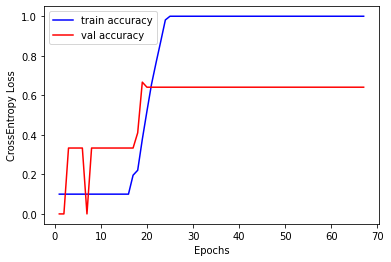

In [ ]:
import copy

runs_mod = copy.deepcopy(runs)
for i in range(len(runs)):
    runs_mod[i] = runs[i] + 1

plt.plot(runs_mod, losses, color = "blue", label = "train accuracy")
plt.plot(runs_mod,val_losses, color = "red", label = "val accuracy")
plt.xlabel("Epochs")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.show()

# Making predictions on test-set

The model is now trained (to whatever epoch you stopped the execution of the training cell at) and can now be used to make predictions on the test set. The weights and biases of the trained model may be checked by calling `model.state_dict()

Converting test dataset to `dtype=torch.Tensor`, and passing it through the model:

In [ ]:
# test = pd.read_csv('./province.v2i.yolov5pytorch/test/test.csv')
test = pd.read_csv('./province.v2i.yolov5pytorch/train/Province.csv')

In [ ]:
X_test = []

for i in test.id:
    img = cv2.imread('./province.v2i.yolov5pytorch/train/test_set/' + str(i)+'.jpg' ,cv2.IMREAD_GRAYSCALE)
    # img = Image.open('./province.v2i.yolov5pytorch/test/images/' + str(i) + '.jpg')
    img_n = np.asarray(img)
    img_n = img_n/255
    img_n = (img_n - 0.5)/0.5
    X_test.append(img_n)

X_test = np.array(X_test)
X_test = X_test.astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)
X_test = torch.from_numpy(X_test)
print(X_test.shape)
# test_img = Image.open('./province.v2i.yolov5pytorch/test-images/test2.jpg')
# test_img = np.asarray(test_img)
# test_img = test_img/255
# test_img = (test_img - 0.5)/0.5
# X_test.append(test_img)
# X_test = np.array(X_test)
# X_test = X_test.astype(np.float32)
# X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)
# X_test = torch.from_numpy(X_test)


torch.Size([1000, 1, 64, 64])


In [ ]:
test_preds = model(X_test.cuda())


The above is the raw output from the model, for the test set. This needs to be passed into the `nn.functional.softmax` function, so that probabilities (that sum up to 1) are returned.

In [ ]:
from torch.nn import functional as F

p = F.softmax(test_preds).data
# print(p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


The following cell will convert the predictions into a CPU Tensor from a GPU/CUDA Tensor:

In [ ]:
p = p.cpu()
# print(p)

Note the fact that the choice of dimension needs to be explicitly specified. I am saved from that headache (for now) by the Jupyter kernel. Good guy Jupyter!

The `softmax` probability outputs are now passed through the `argmax` function, which returns the index of the element with the highest probability. This is great for us, since our encodings for the numerals are from 1-15. 

**HOWEVER**, the `argmax` function's outputs begin from `0` (as is the convention with Python), so care needs to be taken to append the correct values. This can easily be achieved adding 1 to the output.

**ALSO**, since the input is a tensor, even though the `argmax` output is a single number, it will be of `dtype=<torch.Tensor>`. Since it doesn't make sense to append a `torch.Tensor` to a `DataFrame`, I'll need to pull the numeric value of the `argmax` output from the `torch.Tensor`. This is done by using the `.item()` method in `PyTorch`.

In [ ]:
code = []

for i in range(len(p)):
    cache = np.argmax(p[i])
    code.append(cache.item())

print(code)

[0, 0, 0, 0, 0, 4, 4, 4, 0, 4, 0, 0, 4, 6, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 5, 0, 4, 0, 0, 6, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 6, 0, 0, 0, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 1, 4, 1, 1, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 2, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

***Sanity check*** - looking at the number of elements, and at the distribution of unique values.

In [ ]:
print("The length of the set of predicted values is: ", len(code))
print("Value vs. Value Counts:")
print(pd.Series(code).value_counts())

The length of the set of predicted values is:  1
Value vs. Value Counts:
9    1
dtype: int64


# Making the submission file

The `submission.csv` needs to be in the given format: one column for `id` (which is also the file-name of the image in `./Testing_Data`) and one column for `code`, which includes the encodings of the predicted labels (as per the given naming convention).

Viewing the first 10 entries of the `DataFrame`:

In [ ]:
test['pred'] = code
test.head(10)

,Unnamed: 0,id,code,pred
0,0,test_original_gan2.jpg_002aade7-13aa-4dbc-af34...,0,0
1,1,test_original_gan2.jpg_006c1d71-f084-46de-ba81...,0,0
2,2,test_original_gan2.jpg_032563cf-5181-4f06-aed7...,0,0
3,3,test_original_gan2.jpg_051c4eaa-365b-4a04-9852...,0,0
4,4,test_original_gan2.jpg_05b3cd47-b274-4c91-aab9...,0,0
5,5,test_original_gan2.jpg_08397916-94bf-48d8-913a...,0,4
6,6,test_original_gan2.jpg_0a97facd-fcf7-4181-8d78...,0,4
7,7,test_original_gan2.jpg_0be36682-2629-410f-a1e6...,0,4
8,8,test_original_gan2.jpg_0c61fd6e-0046-4667-a5a2...,0,0
9,9,test_original_gan2.jpg_0f81bd84-a370-4c2f-8a86...,0,4


Checking the distribution of the predicted labels:

In [ ]:
test.pred.value_counts()

In [ ]:
count = 0
for i in range(len(test.pred)):
  if test.pred[i] == test.code[i]:
    count+= 1
count/len(test.pred)

0.851

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test.code, test.pred)

array([[ 88,   0,   0,   1,  21,   2,   8,   0,   0,   0],
       [  0,  25,   0,   0,  73,   1,   0,   0,   0,   0],
       [  0,   0,  94,   0,   0,   0,   8,   0,   0,   0],
       [  0,   0,   0, 122,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  82,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,  99,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  96,   0,   0,   0],
       [  0,   0,   0,   0,  19,   0,   0,  69,   0,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,  99,   3],
       [  0,   0,   0,   0,   3,   0,   7,   0,   0,  77]])

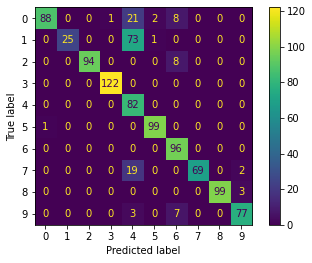

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
cm = confusion_matrix(test.code, test.pred, labels= [0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='d') 

And finally, writing the `test` `DataFrame` to a `.csv`:

In [ ]:
test.to_csv('./exp3.csv', index = False)

In [ ]:
import pandas as pd
data = pd.read_csv('./exp5.csv')

In [ ]:
data.head()

,Unnamed: 0,id,code,pred
0,0,wan,5,8
1,1,wan_jpg.rf.03b0cab5d31957596feb746f3f8e0f56,5,5
2,2,wan_jpg.rf.1c9cf5685f5f6f0bbc3158d386f5a519,5,5
3,3,wan_jpg.rf.237d5c82388779c9c3194703fe683015,5,5
4,4,wan_jpg.rf.3a33af62d0aae96d127bad7599b6b3b9,5,5
